# 1. Collecting the Data

In [1]:
#import necessary libraries 
#utilize pytorch structure

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

In [2]:
#define class path and format 

class AnimeDataset(Dataset):
    
    def __init__(self, img_dir):
        path_list = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir)

        self.img_list = [os.path.join(abspath, path) for path in path_list if path.endswith('.png')]

        self.transform = transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  #normalize text [-1,1]
        ])


    def __len__(self):
        return len(self.img_list)


    def __getitem__(self, index):
        path = self.img_list[index]
        img = Image.open(path).convert('RGB')
        return self.transform(img)

# 2. Preparing the models 

In [3]:
#Define discriminator module layers and parameters

class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, conv_dim, 4, 2, 1, bias=False),
            nn.SiLU(),
#             nn.LeakyReLU(0.2, inplace=True),
   
            nn.Conv2d(conv_dim, conv_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.SiLU(),
#             nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(conv_dim * 2, conv_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.SiLU(),
#             nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(conv_dim * 4, conv_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 8),
            nn.SiLU(),
#             nn.LeakyReLU(0.2, inplace=True),
          
            nn.Conv2d(conv_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, x):
        return self.main(x)

In [4]:
#Define generator module layers and parameters

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=64):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d( z_size, conv_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(conv_dim * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(conv_dim * 8, conv_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.ReLU(True),
           
            nn.ConvTranspose2d( conv_dim * 4, conv_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.ReLU(True),
           
            nn.ConvTranspose2d( conv_dim * 2, conv_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(True),
          
            nn.ConvTranspose2d( conv_dim, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )


    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1) 
        return self.main(x)

In [5]:
#Utilize Deep Convolutional Generative Adversarial Network
#Set priority to GPU (cuda)

class DCGAN:

    def __init__(self, z_size, conv_dim):
        self.z_size = z_size

        self.D = Discriminator(conv_dim)
        self.G = Generator(z_size, conv_dim)

        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
        self.D.to(self.device)
        self.G.to(self.device)

        self.D.apply(self.weights_init)
        self.G.apply(self.weights_init)

    #Define layer parameters
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
            
        
    def __calculate_loss(self, output, labels):
        criterion = nn.BCELoss()
        return criterion(output.squeeze(), labels)


    def real_loss(self, D_out):
        batch_size = D_out.size(0)
        labels = torch.ones(batch_size).to(self.device)*0.8

        return self.__calculate_loss(D_out, labels) 


    def fake_loss(self, D_out):
        batch_size = D_out.size(0)
        labels = torch.ones(batch_size).to(self.device)*0.1
 
        return self.__calculate_loss(D_out, labels)


    def noise(self, size):
        z = np.random.uniform(-1, 1, size=size)
        return torch.from_numpy(z).float().to(self.device)


    def train_generator(self, g_optim, size):
        g_optim.zero_grad()

        z = self.noise(size)
        fake_images = self.G(z)
        
        d_fake = self.D(fake_images)

        g_loss = self.real_loss(d_fake)

        g_loss.backward()
        g_optim.step()

        return g_loss.item()

    
    def train_discriminator(self, d_optim, real_images, size):
        d_optim.zero_grad()

        d_real = self.D(real_images.to(self.device)).view(-1)
        d_real_loss = self.real_loss(d_real)

        z = self.noise(size)
        fake_images = self.G(z)
      
        d_fake = self.D(fake_images)
        d_fake_loss = self.fake_loss(d_fake)

        d_loss = d_real_loss + d_fake_loss

        d_loss.backward()
        d_optim.step()

        return d_loss.item()
    
    
    def save_sample(self, z, samples):
        self.G.eval()
        samples.append( self.G(z) )
        self.G.train()
               
        
    def save_model(self, loss, s_print):
        torch.save(self.G.state_dict(), "Generator")
        torch.save(self.D.state_dict(), "Discriminator")
        if s_print:
            print('Saved best: {:6.4f}'.format(loss))
    
    
    def print_train_log(self, epoch, num_epochs, d_loss, g_loss):
        print('Epoch [{:5d}/{:5d}] | d_loss {:6.4f} | g_loss {:6.4f}'.format(
            epoch+1,
            num_epochs,
            d_loss,
            g_loss
        ))
    
        
    def train(self, num_epochs, d_optim, g_optim, data_loader, z_size, sample_size, print_every=500):
        samples, losses = [], []
        g_total_loss = np.Inf

        z = self.noise((sample_size, z_size))

        self.D.train()
        self.G.train()

        print(f'Running on {self.device}')
        for epoch in range(num_epochs):
            for i, real_images in enumerate(data_loader):                    
                batch_size = real_images.size(0)

                d_loss = self.train_discriminator(d_optim, real_images, (sample_size, z_size))
                g_loss = self.train_generator(g_optim, (sample_size, z_size))
                
                # print train log
                if i % print_every == 0: 
                    self.print_train_log(epoch, num_epochs, d_loss, g_loss)
                
                # Save model
                if g_loss < g_total_loss:
                    g_total_loss = g_loss
                    self.save_model(g_total_loss, (i%print_every==0))
            
            # store losses and save sample
            losses.append( (d_loss, g_loss) )
            self.save_sample(z, samples)
            
        with open('anime_sample.pkl', 'wb') as f:
            pkl.dump(samples, f)

        return samples, losses 

# 3. Preparing the data

In [6]:
#import dataset from google drive

from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/out2.zip


Streaming output truncated to the last 5000 lines.
  inflating: seed28784.png           
  inflating: seed28785.png           
  inflating: seed28786.png           
  inflating: seed28787.png           
  inflating: seed28788.png           
  inflating: seed28789.png           
  inflating: seed2879.png            
  inflating: seed28790.png           
  inflating: seed28791.png           
  inflating: seed28792.png           
  inflating: seed28793.png           
  inflating: seed28794.png           
  inflating: seed28795.png           
  inflating: seed28796.png           
  inflating: seed28797.png           
  inflating: seed28798.png           
  inflating: seed28799.png           
  inflating: seed2880.png            
  inflating: seed28800.png           
  inflating: seed28801.png           
  inflating: seed28802.png           
  inflating: seed28803.png           
  inflating: seed28804.png           
  inflating: seed28805.png           
  inflating: seed28806.png           

In [7]:
#call dataset from drive content

DATA_DIR = '/content'


BATCH_SIZE = 32
N_WORKERS = 0

Z_SIZE = 128
SAMPLE_SIZE = 16
CONV_DIM = 64

lr = 0.0002
beta1=0.5
beta2=0.999

EPOCHS = 30

# 4. Model training 

In [8]:
# Call the dataset
anime_dataset = AnimeDataset(DATA_DIR)
data_loader = DataLoader(anime_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)


# Define the model
dcgan_model = DCGAN(Z_SIZE, CONV_DIM)

# Set optimizer parameters
d_optimizer = optim.Adam(dcgan_model.D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(dcgan_model.G.parameters(), lr, [beta1, beta2])

# Begin training of data
sample_result, losses_history = dcgan_model.train(EPOCHS, d_optimizer, g_optimizer, data_loader, Z_SIZE, SAMPLE_SIZE,
                                                  print_every=1000)

Running on cuda
Epoch [    1/   30] | d_loss 1.4158 | g_loss 2.4655
Saved best: 2.4655
Epoch [    2/   30] | d_loss 1.0071 | g_loss 1.7154
Epoch [    3/   30] | d_loss 1.0985 | g_loss 1.5045
Epoch [    4/   30] | d_loss 1.1008 | g_loss 1.7702
Epoch [    5/   30] | d_loss 0.9682 | g_loss 1.9603
Epoch [    6/   30] | d_loss 0.9800 | g_loss 1.5101
Epoch [    7/   30] | d_loss 1.1435 | g_loss 0.9663
Epoch [    8/   30] | d_loss 1.0816 | g_loss 1.1756
Epoch [    9/   30] | d_loss 0.9268 | g_loss 1.6800
Epoch [   10/   30] | d_loss 0.8933 | g_loss 1.9147
Epoch [   11/   30] | d_loss 0.8856 | g_loss 1.7462
Epoch [   12/   30] | d_loss 0.8962 | g_loss 2.5467
Epoch [   13/   30] | d_loss 0.8989 | g_loss 1.9325
Epoch [   14/   30] | d_loss 0.8753 | g_loss 2.1278
Epoch [   15/   30] | d_loss 0.9831 | g_loss 1.8322
Epoch [   16/   30] | d_loss 0.9247 | g_loss 2.3352
Epoch [   17/   30] | d_loss 0.8775 | g_loss 1.6522
Epoch [   18/   30] | d_loss 0.8749 | g_loss 2.2082
Epoch [   19/   30] | d_loss 

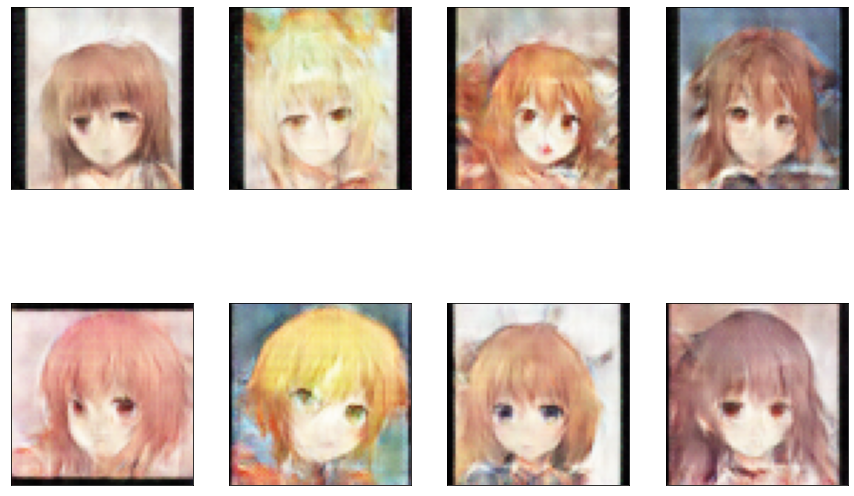

In [9]:
#Show results of training
#Define image characteristics for display

fig, axes = plt.subplots(figsize=(15,10), nrows=2, ncols=4, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), sample_result[EPOCHS-1]):
    _, w, h = img.size()
     
    img = img.detach().cpu().numpy()

    img = np.transpose(img, (1, 2, 0))
    
    img = ((img +1)*255 / (2)).astype(np.uint8)

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    im = ax.imshow(img.reshape((w,h,3)))

plt.show()

# 5. Evaluating the model

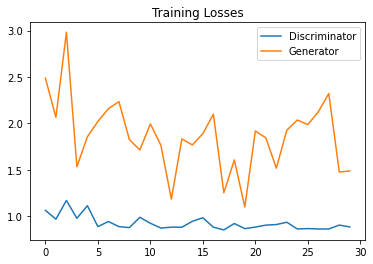

In [10]:
#Show training loss comparison
#Generator loss peaks at 2.9
#Discriminator loss is around 0.5

fig, ax = plt.subplots()
losses = np.array(losses_history)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()